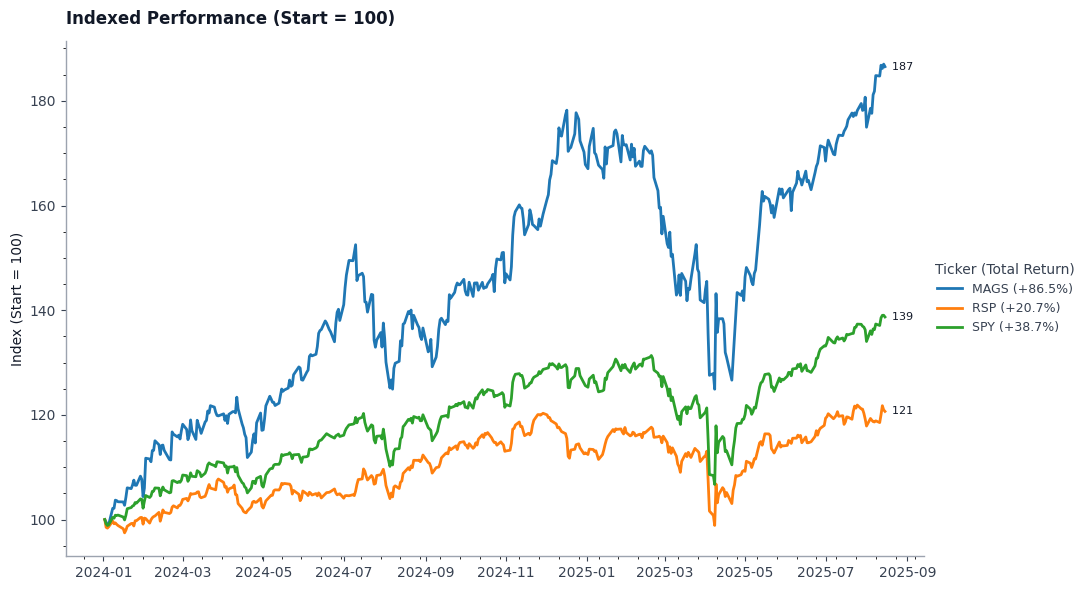

In [6]:
# finance_dual_charts.py
# One file: (A) customizable single-ticker chart; (B) multi-ticker indexed-to-100 chart.

import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, AutoMinorLocator
from typing import Optional, Iterable, Dict, List

# =========================
# ======= THEMES ==========
# =========================
LIGHT_MODE = {
    "FIGURE_BACKGROUND":  "#ffffff",
    "PLOT_BACKGROUND":    "#ffffff",
    "AXIS_LINE_COLOR":    "#9ca3af",
    "TICK_COLOR":         "#374151",
    "AXIS_LABEL_COLOR":   "#111827",
    "TITLE_COLOR":        "#111827",
    "SUBTITLE_COLOR":     "#4b5563",
    "LEGEND_TEXT_COLOR":  "#374151",
    "GRID_COLOR":         "#e5e7eb",
    "MAIN_LINE_COLOR":    "#2563eb",  # used by single-ticker price line
    "MA_COLOR":           "#6b7280",  # moving averages
}

DARK_MODE = {
    "FIGURE_BACKGROUND":  "#111214",
    "PLOT_BACKGROUND":    "#111214",
    "AXIS_LINE_COLOR":    "#6b7280",
    "TICK_COLOR":         "#e5e7eb",
    "AXIS_LABEL_COLOR":   "#ffffff",
    "TITLE_COLOR":        "#ffffff",
    "SUBTITLE_COLOR":     "#cbd5e1",
    "LEGEND_TEXT_COLOR":  "#e5e7eb",
    "GRID_COLOR":         "#384151",
    "MAIN_LINE_COLOR":    "#0ea5e9",
    "MA_COLOR":           "#9ca3af",
}

# =========================
# ========= OPTIONS =======
# =========================
OPTIONS = {
    # Which chart to run: "single" or "indexed"
    "RUN_MODE": "indexed",  # change to "indexed" for multi-ticker indexed chart

    # ---- shared basics ----
    "MODE": "light",          # "light" or "dark"
    "HIDE_TOP_RIGHT": True,  # hide top & right spines

    # ---- grid toggles (work for both charts) ----
    "GRID_ON": False,
    "GRID_AXIS": "both",         # "both" | "x" | "y"
    "GRID_WHICH": "major",       # "major" | "minor" | "both"
    "GRID_LINESTYLE": "--",      # "-", "--", ":", "-."
    "GRID_ALPHA": 0.35,
    "MINOR_TICKS": True,         # enable minor ticks

    # ---- single-ticker options ----
    "TICKER": "AAPL",
    "START_SINGLE": "2024-01-01",
    "END_SINGLE": None,          # or "YYYY-MM-DD"
    "SHOW_MA": False,
    "MA_WINDOWS": (50, 200),
    "PRICE_LINEWIDTH": 2.2,
    "MA_LINEWIDTH": 1.4,
    "SAVE_SINGLE_PATH": None,    # e.g., "aapl_dark.png"

    # ---- multi-ticker indexed options ----
    "TICKERS": ["SPY", "MAGS", "RSP"],  # list of tickers
    "START_INDEXED": "2024-01-01",
    "END_INDEXED": None,
    "INDEXED_LINEWIDTH": 2.0,
    "SAVE_INDEXED_PATH": None,          # e.g., "indexed.png"
}

# =========================
# ===== IMPLEMENTATION ====
# =========================

def _currency_fmt(ax):
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"${y:,.0f}"))

def _apply_style(
    fig, ax,
    style: dict,
    *,
    hide_top_right: bool,
    grid_on: bool,
    grid_axis: str,
    grid_which: str,
    grid_linestyle: str,
    grid_alpha: float,
    minor_ticks: bool,
):
    # backgrounds
    fig.patch.set_facecolor(style["FIGURE_BACKGROUND"])
    ax.set_facecolor(style["PLOT_BACKGROUND"])

    # spines
    for side in ("left", "bottom"):
        ax.spines[side].set_color(style["AXIS_LINE_COLOR"])
        ax.spines[side].set_linewidth(1.0)
    if hide_top_right:
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
    else:
        for side in ("top", "right"):
            ax.spines[side].set_color(style["AXIS_LINE_COLOR"])
            ax.spines[side].set_linewidth(1.0)
            ax.spines[side].set_visible(True)

    # ticks & labels
    ax.tick_params(axis="x", colors=style["TICK_COLOR"])
    ax.tick_params(axis="y", colors=style["TICK_COLOR"])
    ax.xaxis.label.set_color(style["AXIS_LABEL_COLOR"])
    ax.yaxis.label.set_color(style["AXIS_LABEL_COLOR"])

    # minor ticks if requested
    if minor_ticks:
        try: ax.xaxis.set_minor_locator(AutoMinorLocator())
        except Exception: pass
        try: ax.yaxis.set_minor_locator(AutoMinorLocator())
        except Exception: pass

    # grid
    if grid_on:
        ax.grid(
            True,
            which=grid_which,
            axis=grid_axis,
            color=style["GRID_COLOR"],
            linestyle=grid_linestyle,
            alpha=grid_alpha,
        )
    else:
        ax.grid(False)

def _style_from_mode(mode: str) -> dict:
    return DARK_MODE if str(mode).lower() == "dark" else LIGHT_MODE

# -------- data helpers --------
def fetch_close_series(ticker: str, start: str, end: Optional[str]) -> pd.Series:
    df = yf.download(ticker, start=start, end=end, auto_adjust=True, progress=False)
    if df.empty:
        raise ValueError(f"No data for {ticker}.")
    s = df["Close"]
    if isinstance(s, pd.DataFrame):
        s = s.squeeze("columns")
    return s.dropna()

def fetch_close_df(tickers: List[str], start: str, end: Optional[str]) -> pd.DataFrame:
    """Return a 2D DataFrame of adjusted close for multiple tickers."""
    raw = yf.download(tickers, start=start, end=end, auto_adjust=True, progress=False)
    if raw.empty:
        raise ValueError(f"No data for tickers: {tickers}")
    if isinstance(raw.columns, pd.MultiIndex):
        data = raw["Close"]
    else:
        # single-column case fallback
        first = tickers[0]
        data = raw[["Close"]].rename(columns={"Close": first})
    data = data.ffill().dropna()
    return data

def _first_index_on_or_after(idx: pd.DatetimeIndex, date: pd.Timestamp) -> Optional[pd.Timestamp]:
    pos = idx.searchsorted(date)
    return idx[pos] if pos < len(idx) else None

def compute_period_returns(close: pd.Series) -> Dict[str, float]:
    """% returns for common lookbacks, plus Total since series start."""
    last = float(close.iloc[-1])
    idx = close.index
    refs = {
        "1D": idx[-2] if len(idx) >= 2 else None,
        "1W": idx[-5] if len(idx) >= 5 else None,
        "1M": _first_index_on_or_after(idx, idx[-1] - pd.DateOffset(months=1)),
        "YTD": _first_index_on_or_after(idx, pd.Timestamp(year=idx[-1].year, month=1, day=1)),
        "1Y": _first_index_on_or_after(idx, idx[-1] - pd.DateOffset(years=1)),
        "3Y": _first_index_on_or_after(idx, idx[-1] - pd.DateOffset(years=3)),
        "5Y": _first_index_on_or_after(idx, idx[-1] - pd.DateOffset(years=5)),
    }
    out = {}
    for k, ts in refs.items():
        if ts is None: 
            continue
        base = float(close.loc[ts])
        out[k] = (last / base - 1.0) * 100.0
    out["Total"] = (last / float(close.iloc[0]) - 1.0) * 100.0
    return out

# -------- single-ticker chart --------
def plot_ticker(
    ticker: str,
    start: str,
    end: Optional[str] = None,
    show_ma: bool = True,
    ma_windows: Iterable[int] = (50, 200),
    price_lw: float = 2.2,
    ma_lw: float = 1.4,
    grid_on: bool = False,
    grid_axis: str = "both",
    grid_which: str = "major",
    grid_linestyle: str = "--",
    grid_alpha: float = 0.35,
    minor_ticks: bool = True,
    save_path: Optional[str] = None,
    mode: str = "dark",
    style: Optional[dict] = None,
    hide_top_right: bool = True,
    show: bool = True,
):
    style = style or _style_from_mode(mode)

    close = fetch_close_series(ticker, start, end)
    first_dt = close.index[0].strftime("%b %d, %Y")
    last_dt  = close.index[-1].strftime("%b %d, %Y")
    last_price = float(close.iloc[-1])
    rets = compute_period_returns(close)

    fig, ax = plt.subplots(figsize=(11, 6))
    _apply_style(
        fig, ax, style,
        hide_top_right=hide_top_right,
        grid_on=grid_on,
        grid_axis=grid_axis,
        grid_which=grid_which,
        grid_linestyle=grid_linestyle,
        grid_alpha=grid_alpha,
        minor_ticks=minor_ticks,
    )
    _currency_fmt(ax)

    # main price line
    ax.plot(
        close.index, close.values,
        color=style["MAIN_LINE_COLOR"],
        linewidth=price_lw,
        label=f"{ticker.upper()}  |  Total {rets.get('Total', float('nan')):.1f}%"
    )

    # moving averages
    if show_ma:
        for w in ma_windows:
            if w < len(close):
                ax.plot(
                    close.index, close.rolling(w).mean().values,
                    color=style["MA_COLOR"], linewidth=ma_lw, alpha=0.9, label=f"MA{w}"
                )

    # axes & labels
    ax.set_title(
        f"{ticker.upper()} — Adjusted Close",
        loc="left", pad=12, fontweight="bold", color=style["TITLE_COLOR"]
    )
    ax.set_xlabel("")
    ax.set_ylabel("Price (USD)")

    # annotate last price
    ax.annotate(
        f"${last_price:,.2f}",
        xy=(close.index[-1], last_price),
        xytext=(10, 0),
        textcoords="offset points",
        va="center",
        fontsize=10,
        color=style["AXIS_LABEL_COLOR"],
        bbox=dict(boxstyle="round,pad=0.2",
                  fc=style["PLOT_BACKGROUND"],
                  ec=style["AXIS_LINE_COLOR"],
                  alpha=0.85),
    )

    # subtitle with returns
    buckets = ["1D", "1W", "1M", "YTD", "1Y", "3Y", "5Y"]
    ret_bits = "   ·   ".join(f"{k}: {rets[k]:+.1f}%" for k in buckets if k in rets)
    subtitle = f"{first_dt} → {last_dt}   |   {ret_bits}"
    ax.text(0.01, 1, subtitle, transform=ax.transAxes, fontsize=10, color=style["SUBTITLE_COLOR"])

    # legend
    leg = ax.legend(loc="upper left", frameon=False, fontsize=9)
    for txt in leg.get_texts():
        txt.set_color(style["LEGEND_TEXT_COLOR"])

    plt.tight_layout()
    try:
        if save_path:
            plt.savefig(save_path, dpi=220, bbox_inches="tight", facecolor=style["FIGURE_BACKGROUND"])
        if show:
            plt.show()
    finally:
        plt.close(fig)

# -------- multi-ticker indexed-to-100 chart --------
def plot_indexed(
    tickers: List[str],
    start: str,
    end: Optional[str] = None,
    linewidth: float = 2.0,
    grid_on: bool = True,
    grid_axis: str = "both",
    grid_which: str = "major",
    grid_linestyle: str = "--",
    grid_alpha: float = 0.30,
    minor_ticks: bool = True,
    save_path: Optional[str] = None,
    mode: str = "dark",
    style: Optional[dict] = None,
    hide_top_right: bool = True,
    show: bool = True,
):
    style = style or _style_from_mode(mode)

    data = fetch_close_df(tickers, start, end)
    indexed = data / data.iloc[0] * 100.0
    tot_ret = (indexed.iloc[-1] / indexed.iloc[0] - 1.0).sort_values(ascending=False)

    # Pretty column labels like "SPY (+8.3%)"
    nice = indexed.copy()
    nice.columns = [f"{t} ({tot_ret[t]*100:+.1f}%)" for t in indexed.columns]

    fig, ax = plt.subplots(figsize=(11, 6))
    _apply_style(
        fig, ax, style,
        hide_top_right=hide_top_right,
        grid_on=grid_on,
        grid_axis=grid_axis,
        grid_which=grid_which,
        grid_linestyle=grid_linestyle,
        grid_alpha=grid_alpha,
        minor_ticks=minor_ticks,
    )

    # Plot each series manually so we can use theme colors (fallback to Matplotlib cycle)
    # For variety, we use the default color cycle; you can force a fixed color if you prefer.
    for col in nice.columns:
        ax.plot(nice.index, nice[col].values, linewidth=linewidth)

    ax.set_title("Indexed Performance (Start = 100)", loc="left", pad=12,
                 fontweight="bold", color=style["TITLE_COLOR"])
    ax.set_xlabel("")
    ax.set_ylabel("Index (Start = 100)")

    # Legend outside to keep things clean
    leg = ax.legend(nice.columns, title="Ticker (Total Return)",
                    loc="center left", bbox_to_anchor=(1.0, 0.5), frameon=False, fontsize=9)
    if leg.get_title():
        leg.get_title().set_color(style["LEGEND_TEXT_COLOR"])
    for txt in leg.get_texts():
        txt.set_color(style["LEGEND_TEXT_COLOR"])

    # Annotate last value at endpoints
    last_vals = nice.iloc[-1]
    for col in nice.columns:
        ax.text(nice.index[-1], last_vals[col], f"  {last_vals[col]:.0f}",
                va="center", fontsize=8, color=style["AXIS_LABEL_COLOR"])

    plt.tight_layout()
    try:
        if save_path:
            plt.savefig(save_path, dpi=220, bbox_inches="tight", facecolor=style["FIGURE_BACKGROUND"])
        if show:
            plt.show()
    finally:
        plt.close(fig)

# =========================
# ========= RUN ===========
# =========================
if __name__ == "__main__":
    style = _style_from_mode(OPTIONS["MODE"])

    if OPTIONS["RUN_MODE"] == "single":
        plot_ticker(
            ticker=OPTIONS["TICKER"],
            start=OPTIONS["START_SINGLE"],
            end=OPTIONS["END_SINGLE"],
            show_ma=OPTIONS["SHOW_MA"],
            ma_windows=OPTIONS["MA_WINDOWS"],
            price_lw=OPTIONS["PRICE_LINEWIDTH"],
            ma_lw=OPTIONS["MA_LINEWIDTH"],
            grid_on=OPTIONS["GRID_ON"],
            grid_axis=OPTIONS["GRID_AXIS"],
            grid_which=OPTIONS["GRID_WHICH"],
            grid_linestyle=OPTIONS["GRID_LINESTYLE"],
            grid_alpha=OPTIONS["GRID_ALPHA"],
            minor_ticks=OPTIONS["MINOR_TICKS"],
            save_path=OPTIONS["SAVE_SINGLE_PATH"],
            mode=OPTIONS["MODE"],
            style=style,
            hide_top_right=OPTIONS["HIDE_TOP_RIGHT"],
        )
    elif OPTIONS["RUN_MODE"] == "indexed":
        plot_indexed(
            tickers=OPTIONS["TICKERS"],
            start=OPTIONS["START_INDEXED"],
            end=OPTIONS["END_INDEXED"],
            linewidth=OPTIONS["INDEXED_LINEWIDTH"],
            grid_on=OPTIONS["GRID_ON"],
            grid_axis=OPTIONS["GRID_AXIS"],
            grid_which=OPTIONS["GRID_WHICH"],
            grid_linestyle=OPTIONS["GRID_LINESTYLE"],
            grid_alpha=OPTIONS["GRID_ALPHA"],
            minor_ticks=OPTIONS["MINOR_TICKS"],
            save_path=OPTIONS["SAVE_INDEXED_PATH"],
            mode=OPTIONS["MODE"],
            style=style,
            hide_top_right=OPTIONS["HIDE_TOP_RIGHT"],
        )
    else:
        raise ValueError('OPTIONS["RUN_MODE"] must be "single" or "indexed"')
